In [2]:
!pip install diffusers==0.30.0
!pip install transformers scipy ftfy accelerate opencv-python mediapipe
!pip install -U controlnet-aux

  Using cached ftfy-6.2.3-py3-none-any.whl.metadata (7.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/인사교/DL

/content/drive/MyDrive/인사교/DL


#### ControlNet
- Stable Diffusion 의 응용
  - 프롬프트뿐만 아니라, 특정한 조건 추가해서 이미지 생성을 제어하는 기술

In [7]:
from diffusers.utils import load_image, make_image_grid # 이미지 로드, 이미지 그리트 형태로 출력하는 도구
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import StableDiffusionControlNetInpaintPipeline # 인페인팅 전용 파이프라인
from controlnet_aux import OpenposeDetector # 관절 키포인트 추출하는데 사용되는 도구

import torch
from PIL import Image
import cv2
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

#### Inpainting
- 이미지 처리 기술 중 하나
- 손상 된 이미지 영역을 복원하거나, 삭제된 부분을 채워주는 기술

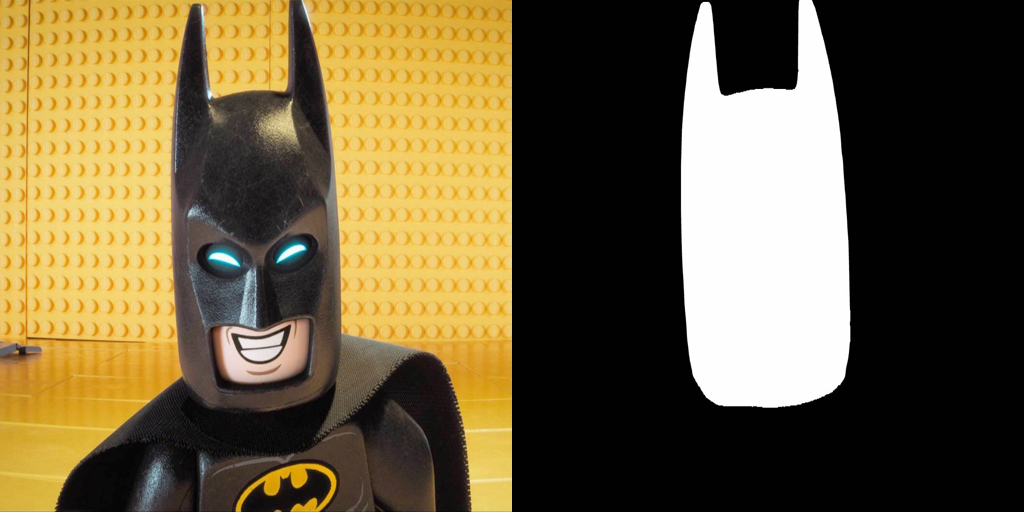

In [8]:
# 원본 이미지
init_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint.jpg"
)

init_image = init_image.resize((512, 512))

# 마스크 이미지
mask_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint-mask.jpg"
)

mask_image = mask_image.resize((512, 512))

make_image_grid([init_image, mask_image], rows = 1, cols = 2)

In [9]:
# 컨디션 이미지(조건 이미지)를 생성하는 함수 정의
def make_inpaint_condition(image, image_mask):
    # RGB 채널로 변환 후, 0 ~ 1 사이로 정규화
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    # L -> 그레이 스케일로 변환 후 0 ~ 1 사이로 정규화
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    # 원본 이미지랑 마스크 이미지랑 높이와 너비가 같은지 확인
    assert image.shape[0:1] == image_mask.shape[0:1]

    # 이미지에서 값이 0.5보다 큰 위치에(마스크 영역)에 해당하는 원본 이미지의 픽셀값을 -1.0으로 설정
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    # 차원 순서를(배치, 채널, 높이, 너비)로 변경
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    # 텐서형으로 변환
    image = torch.from_numpy(image)
    return image

In [10]:
control_image = make_inpaint_condition(init_image, mask_image)

In [12]:
# ControlNet 모델을 사전 학습 된 체크포인트 로드
controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/control_v11p_sd15_inpaint', # 인페인트용 모델
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드함)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [15]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    'sd-legacy/stable-diffusion-v1-5', # 1.5v 경로
    controlnet = controlnet,
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드함)
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [17]:
pipe.enable_model_cpu_offload() # GPU 메모리가 부족할 때 CPU로 일부 이동시켜서 성능 향상

In [21]:
# 이미지 생성
prompt = 'super-hero character, best quality, extremely detailed'

# 생성 시 제외할 요소들을 지정하는 네거티브 프롬프트
negative_prompt = 'monochrome, lowres, bad anatomy, worst quality, low quality'

# 시드 고정
generator = torch.Generator('cuda').manual_seed(2024)

output = pipe(
    prompt,
    image = openpose_image,
    num_inference_steps = 80,
    generator = generator,
    negative_prompt = negative_prompt
).images[0]

NameError: name 'openpose_image' is not defined

In [19]:
make_image_grid([original_image, openpose_image, output], rows = 1, cols = 3)